# Dog breed identification competition

To do:
* Create train and validation set

* Train VGG16 model and validate
    * Finetune to dog breed dataset
    * Figure out what additional pre-processing steps can be done to improve accuracy
    
* Test on test set 

* submit

In [1]:
main_dir = '/home/ubuntu/nbs/courses/deeplearning1/nbs/Dog_breed_identification'

In [2]:

from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import plots
from vgg16 import Vgg16
import pandas as pd
from jupyterthemes import jtplot
import pre_processing as pp
jtplot.reset()
jtplot.style(theme='oceans16',context='talk', fscale=1.4, spines=False, gridlines='--')

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [3]:
os.chdir(main_dir)

In [4]:
train_labels = pd.read_csv('labels.csv')
train_labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


### Create validation set
##### make sure to use stratefied sampling

In [7]:
# %mkdir valid
# breed_probs = num_breed/train_labels.shape[0]
# train_labels['sample_prob'] = 0
# train_labels
# for x in breed_probs.index:
#     indv_prob = breed_probs[x]/num_breed[x]
#     train_labels.loc[train_labels['breed'] == x, 'sample_prob'] = indv_prob

# valid_set_fns = np.random.choice(train_labels['id'], int(len(train_labels['id'])*.3),
#                                    replace = False, p = train_labels['sample_prob'])

# [os.rename(main_dir+'/train/'+x+'.jpg', main_dir+'/valid/'+x+'.jpg')
#  for x in valid_set_fns];


### Organize data into group folders for both validation and training sets

In [ ]:
os.chdir(main_dir+'/valid')
moved_valid_files = glob('*jpg')
moved_valid_files = pd.DataFrame(moved_valid_files, columns = ['id']).applymap(lambda y: y[:-4])
valid_labels = moved_valid_files.merge(train_labels)
os.chdir(main_dir + '/valid')
[pp.organize_groups(valid_labels, breed) for breed in valid_labels['breed'].unique()];

os.chdir(main_dir + '/train')
rem_training_files = pd.DataFrame(glob('*.jpg'), columns = ['id']).applymap(lambda x: x[:-4])
rem_training_labels = rem_training_files.merge(train_labels, how = 'inner', on = 'id')
[pp.organize_groups(rem_training_labels, breed) for breed in rem_training_labels['breed'].unique()];

In [68]:
os.chdir(main_dir + '/train')
file_tree = os.walk(".")
num_per_group_train = pd.DataFrame([(x[0][2:],len(x[2])) for x in file_tree], columns = ['breed', 'freq']).loc[1:,:]

os.chdir(main_dir + '/valid')
file_tree = os.walk(".")
num_per_group_valid = pd.DataFrame([(x[0][2:],len(x[2])) for x in file_tree], columns = ['breed', 'freq']).loc[1:,:]

In [71]:
num_per_group_valid.sort_values(by = ['freq'], ascending=False, inplace = True)
num_per_group_train.sort_values(by = ['freq'], ascending=False, inplace = True)

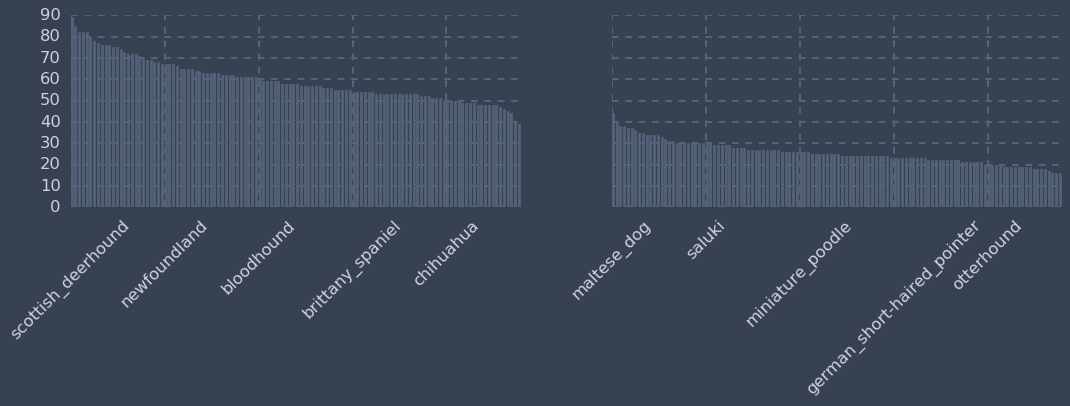

In [92]:
plt.close('all')
fig, (ax1,ax2)= plt.subplots(figsize=(16, 3), ncols = 2, sharey = True)
ax1.bar(np.arange(0,len(num_per_group_train['freq']),1), num_per_group_train['freq'])
xlabels_pos = range(0,len(num_per_group_train['breed']),25)
xlabels = num_per_group_train['breed'].iloc[xlabels_pos].as_matrix()
ax1.set_xticks(xlabels_pos)
ax1.set_xticklabels(xlabels, rotation = 45)

ax2.bar(np.arange(0,len(num_per_group_valid['freq']),1), num_per_group_valid['freq'])
xlabels_pos = range(0,len(num_per_group_valid['breed']),25)
xlabels = num_per_group_valid['breed'].iloc[xlabels_pos].as_matrix()
ax2.set_xticks(xlabels_pos)
ax2.set_xticklabels(xlabels, rotation = 45)

fig

In [9]:


plt.close('all')
fig2 = plt.figure(figsize = (16,4))
num_breed_valid = valid_labels['breed'].value_counts()
ax = fig2.add_subplot(111)
ax.bar(np.arange(0,len(num_breed_valid),1), num_breed_valid)

num_breed_valid = num_breed_valid.reset_index()
num_breed_valid.columns = ['breed', 'count']
original_xlabel_df = pd.DataFrame(xlabels, columns = ['breed'])
xlabels_pos = list(original_xlabel_df.merge(num_breed_valid, how = 'inner', left_index = True, on = ['breed']).index)
ax.set_xticks(xlabels_pos)
ax.set_xticklabels(xlabels, rotation = 'vertical')
fig2

AttributeError: 'Series' object has no attribute 'merge'

### Initialize Vgg16 model and batches generator

In [ ]:
vgg = Vgg16()

In [ ]:
batch_size = 64
num_epochs = 3
batches = vgg.get_batches(main_dir + '/train', batch_size = batch_size)
val_batches = vgg.get_batches(main_dir + '/valid', batch_size = batch_size*2)

### Train model and save weights

In [ ]:
for i in range(3):
    vgg.fit(batches,val_batches,nb_epoch = 1)
    latest_weights_filename = 'ft'+str(i)
    vgg.model.save_weights(main_dir+'/'+latest_weights_filename)

In [ ]:
??vgg.fit

In [ ]:
??vgg